# 1. Importar librerías

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB,ComplementNB

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# 2. Importar set de entrenamiento

In [4]:
data_train = pd.read_json('train.json')
data_train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [5]:
type(data_train['ingredients'][0])

list

Primero se necesita una columna con un string de ingredientes.

In [6]:
#data_train['ingr_lst'] = data_train['ingredients'].apply(lambda x: [item.replace(' ','') for item in x])

In [7]:
data_train['ingr_str'] = data_train['ingredients'].apply(lambda x: ' '.join(x))
data_train.head()

,cuisine,id,ingredients,ingr_str
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...
3,indian,22213,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallots cornflour cayenne pepper...


In [8]:
# data_train['ingr_str2'] = data_train['ingredients'].apply(lambda x: ' '.join(x))
# data_train.head()

In [9]:
data_train['cant_ingr'] = data_train['ingredients'].str.len()
data_train.head()

,cuisine,id,ingredients,ingr_str,cant_ingr
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...,9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...,11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...,12
3,indian,22213,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt,4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallots cornflour cayenne pepper...,20


In [10]:
data_train.shape

(39774, 5)

In [12]:
data_train.drop(index=data_train.loc[(data_train['cant_ingr']==1)|(data_train['cant_ingr']>30)].index,inplace=True)

Ya que los ingredientes a veces vienen como 2 palabras juntas, se decidió tomar esta representación. Luego se harán pruebas tomando la otra columna.

In [13]:
X = data_train['ingr_str']
y = data_train['cuisine']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [15]:
X.shape,y.shape

((39712,), (39712,))

In [16]:
X_train.shape,y_train.shape

((29784,), (29784,))

In [17]:
X_test.shape,y_test.shape

((9928,), (9928,))

In [30]:
vec = CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                      encoding='utf-8', input='content',
                      lowercase=True, max_df=1.0, max_features=5000, min_df=1,
                      ngram_range=(1, 1), preprocessor=None, stop_words='english',
                      strip_accents=None, token_pattern='(?u)\\b\\w\\w\\w+\\b',
                      tokenizer=None, vocabulary=None)

X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

sm = SMOTE(random_state=12)

X_train_res, y_train_res = sm.fit_resample(X_train_vec, y_train)


In [31]:
print('X,y')
print(X.shape,y.shape)

print('X_train,y_train')
print(X_train.shape,y_train.shape)

print('X_test,y_test')
print(X_test.shape,y_test.shape)

print('X_train_res,y_train_res')
print(X_train_res.shape,y_train_res.shape)

X,y
(39712,) (39712,)
X_train,y_train
(29784,) (29784,)
X_test,y_test
(9928,) (9928,)
X_train_res,y_train_res
(117520, 2803) (117520,)


In [32]:
np.unique(y_train_res, return_counts=True)

(array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
        'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
        'japanese', 'korean', 'mexican', 'moroccan', 'russian',
        'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object),
 array([5876, 5876, 5876, 5876, 5876, 5876, 5876, 5876, 5876, 5876, 5876,
        5876, 5876, 5876, 5876, 5876, 5876, 5876, 5876, 5876], dtype=int64))

In [33]:
modelo_NB = MultinomialNB()
modelo_NB.fit(X_train_res, y_train_res)
y_pred_bal = modelo_NB.predict(X_test_vec)

print("Accuracy sobre Train: {}".format(accuracy_score(y_train_res, modelo_NB.predict(X_train_res))))
print("Accuracy sobre Test: {}".format(accuracy_score(y_test, y_pred_bal)))


Accuracy sobre Train: 0.6755871341048332
Accuracy sobre Test: 0.7109186140209508


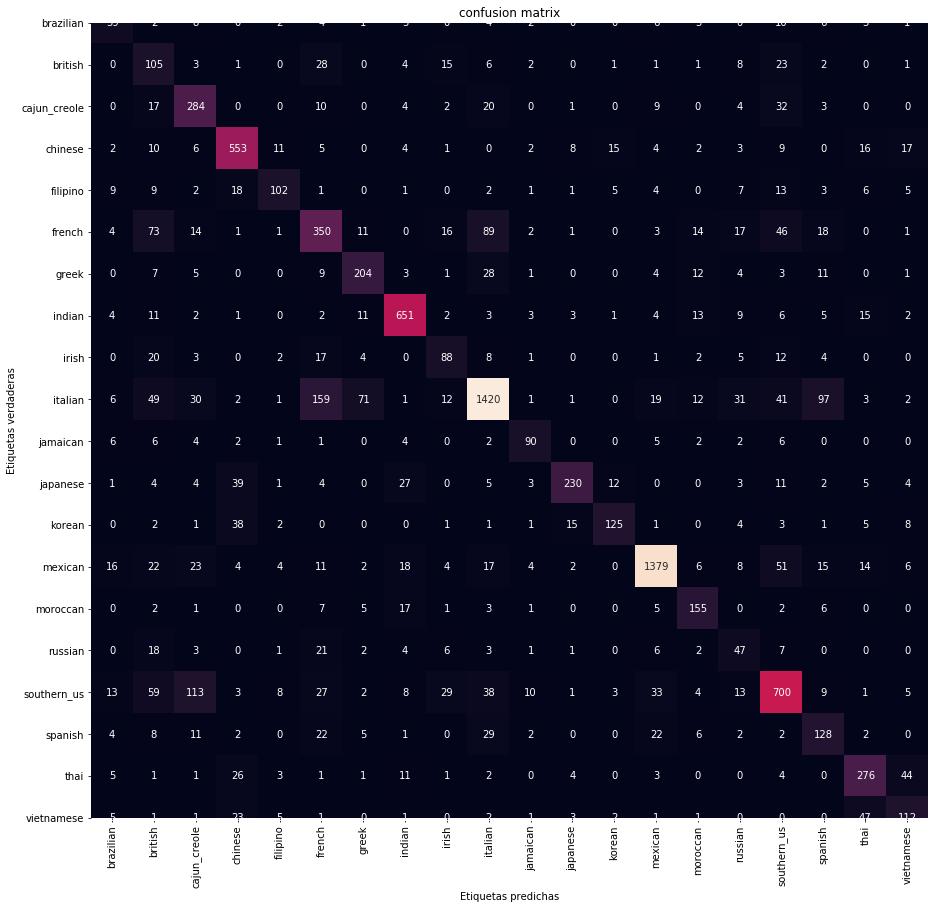

In [34]:

plt.figure(figsize=(15, 15))
classes = unique_labels(y_test, y_pred_bal)

# #tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, labels= classes, rotation=90)
# plt.yticks(tick_marks, labels= classes, rotation=-45)
plt.title("confusion matrix")

mat = confusion_matrix(y_test, y_pred_bal)
ax=sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
    
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')
ax.set_xticklabels(classes,rotation=90)
ax.set_yticklabels(classes,rotation=0);

# SIN BALANCEAR 

# 3. Split en Train y Test

Para armar y validar el modelo dividimos los datos del archivo 'train.json' en train y test. Luego de haber probado y elegido el mejor modelo posible, se realizarán predicciones sobre un nuevo set de datos del archivo 'test.json', del cual no se conocen las etiquetas.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [36]:
X.shape,y.shape

((39712,), (39712,))

In [37]:
X_train.shape,y_train.shape

((29784,), (29784,))

In [38]:
X_test.shape,y_test.shape

((9928,), (9928,))

# 4. Pruebas con CountVectorizer

In [39]:
#vec = CountVectorizer(stop_words='english')
vec1 = CountVectorizer(lowercase=True,stop_words='english',token_pattern=r'(?u)\b\w\w\w+\b',
                       ngram_range=(1,2),max_features=20000)
#vec1 = CountVectorizer(lowercase=True,stop_words='english',token_pattern=r'(?u)\b\w\w\w+\b')


X_train_vec1 = vec1.fit_transform(X_train)
X_test_vec1 = vec1.transform(X_test)
len(vec1.get_feature_names())

20000

In [40]:
#vec = CountVectorizer(stop_words='english')
tfidf1 = TfidfVectorizer(lowercase=True,stop_words='english',token_pattern=r'(?u)\b\w\w\w+\b',
                       ngram_range=(1,2),max_features=20000)
#vec1 = CountVectorizer(lowercase=True,stop_words='english',token_pattern=r'(?u)\b\w\w\w+\b')


X_train_tf1 = tfidf1.fit_transform(X_train)
X_test_tf1 = tfidf1.transform(X_test)
len(tfidf1.get_feature_names())

20000

In [41]:
# vec2 = CountVectorizer(lowercase=True,stop_words='english')
# X_train_vec2 = vec2.fit_transform(X_train)
# len(vec2.get_feature_names())

In [42]:
# word_count=0
# for word in vec2.get_feature_names():
#     if len(word)==2:
#         #print(word)
#         word_count+=1
# word_count

In [43]:
# vec3 = CountVectorizer(lowercase=True,stop_words='english',token_pattern=r'(?u)\b\w\w\w+\b')
# X_train_vec3 = vec3.fit_transform(X_train)
# print(len(vec3.get_feature_names()))
# #print(vec3.get_feature_names())

# 5. Pruebas con Naive Bayes

In [44]:
modelo_NB = MultinomialNB()
modelo_NB.fit(X_train_vec1, y_train)
y_pred1 = modelo_NB.predict(X_test_vec1)

print("Accuracy sobre Train: {}".format(accuracy_score(y_train, modelo_NB.predict(X_train_vec1))))
print("Accuracy sobre Test: {}".format(accuracy_score(y_test, y_pred1)))



Accuracy sobre Train: 0.7776994359387591
Accuracy sobre Test: 0.7232070910556003


In [45]:
modelo_NB = MultinomialNB()
modelo_NB.fit(X_train_tf1, y_train)
y_pred1 = modelo_NB.predict(X_test_tf1)

print("Accuracy sobre Train: {}".format(accuracy_score(y_train, modelo_NB.predict(X_train_tf1))))
print("Accuracy sobre Test: {}".format(accuracy_score(y_test, y_pred1)))


Accuracy sobre Train: 0.6561240934730056
Accuracy sobre Test: 0.6253021756647864


# 6. Búsqueda de los mejores parámetros

Armar un pipeline con un Vectorizer y un estimador de Naive Bayes. 
Armar un gridsearch para cada pipeline definido.

Se probarán los parámetros del vectorizer:
 - max_features
 - ngram_range
 - stop_words
 - binary
 - token_pattern

In [46]:

pipeline1 = Pipeline([
   ('vect', CountVectorizer()), 
   ('clf', MultinomialNB()), 
])

pipeline2 = Pipeline([ 
   ('vect', TfidfVectorizer()), 
   ('clf', MultinomialNB()), 
])

# pipeline3 = Pipeline([ 
#    ('vect', CountVectorizer()), 
#    ('clf', ComplementNB()), 
# ])


In [47]:
parameters = {
    'vect__max_features': [5000,10000,15000,20000,25000,30000],
    'vect__ngram_range': ((1, 1), (1, 2)),
    'vect__stop_words': ['english', None],
    'vect__binary': [True,False],
    'vect__token_pattern' : [r'(?u)\b\w\w\w+\b'],
}

In [48]:

grid_search1 = GridSearchCV (pipeline1, parameters, n_jobs = 4 , verbose = 2 , cv=5)
grid_search2 = GridSearchCV (pipeline2, parameters, n_jobs = 4 , verbose = 2 , cv=5)
# grid_search3 = GridSearchCV (pipeline3, parameters, n_jobs = 4 , verbose = 2 , cv=5)
#grid_search_imb = GridSearchCV (pipeline_imb, parameters, n_jobs = 4 , verbose = 2 , cv=5)

In [50]:
# print("Performing grid search with smote...") 
# grid_search_imb.fit(X_train, y_train)

# print("Best score: %0.3f" % grid_search_imb.best_score_) 
# print("Best parameters set:" )
# best_parameters = grid_search_imb.best_estimator_.get_params()
# for param_name in sorted (parameters . keys()): 
#                     print("\t %s: %r" % (param_name, best_parameters[param_name])) 

In [ ]:
# pipe_best_imb = imbPipeline([
#    ('vect', CountVectorizer(binary=grid_search_imb.best_params_['vect__binary'],
#                             max_features=grid_search_imb.best_params_['vect__max_features'],
#                             ngram_range=grid_search_imb.best_params_['vect__ngram_range'],
#                             stop_words=grid_search_imb.best_params_['vect__stop_words'],
#                             token_pattern=grid_search_imb.best_params_['vect__token_pattern'])),
#     ('smt',SMOTE()),
#     ('clf', MultinomialNB())])

In [ ]:
# pipe_best_imb.fit(X_train,y_train)
# pred_imb=pipe_best_imb.predict(X_test)

# print("Accuracy sobre Test: {}".format(accuracy_score(y_test, pred_imb)))

In [51]:
print("Performing grid search1...") 
grid_search1.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search1.best_score_) 
print("Best parameters set:" )
best_parameters = grid_search1.best_estimator_.get_params()
for param_name in sorted (parameters . keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name])) 

Performing grid search1...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   17.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  2.5min finished


Best score: 0.727
Best parameters set:
	 vect__binary: True
	 vect__max_features: 5000
	 vect__ngram_range: (1, 1)
	 vect__stop_words: 'english'
	 vect__token_pattern: '(?u)\\b\\w\\w\\w+\\b'


In [52]:
print("Performing grid search2...") 
grid_search2.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search2.best_score_) 
print("Best parameters set:" )
best_parameters = grid_search2.best_estimator_.get_params()
for param_name in sorted (parameters . keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name])) 

Performing grid search2...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  2.2min finished


Best score: 0.673
Best parameters set:
	 vect__binary: True
	 vect__max_features: 5000
	 vect__ngram_range: (1, 2)
	 vect__stop_words: 'english'
	 vect__token_pattern: '(?u)\\b\\w\\w\\w+\\b'


In [53]:
# print("Performing grid search3...") 
# grid_search3.fit(X_train, y_train)

# print("Best score: %0.3f" % grid_search3.best_score_) 
# print("Best parameters set:" )
# best_parameters = grid_search3.best_estimator_.get_params()
# for param_name in sorted (parameters . keys()): 
#                     print("\t %s: %r" % (param_name, best_parameters[param_name])) 

In [54]:
grid_search1.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=True,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=5000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [55]:
print(grid_search1.best_estimator_)
print(grid_search1.best_score_)
print(grid_search1.best_params_)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=True,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=5000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)
0.7270346494762289
{'vect__binary': True, 'vect__max_features': 5000, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english', 'vect__token_pattern': '(?u)\\b\\w\\w\\w+\\b'}


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])
0.7271203486423065
{'vect__binary': True, 'vect__max_features': 5000, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english', 'vect__token_pattern': '(?u)\\b\\w\\w\\w+\\b'}

In [56]:
print(grid_search1.best_params_['vect__binary'],grid_search1.best_params_['vect__max_features'])
print(grid_search1.best_params_['vect__ngram_range'],grid_search1.best_params_['vect__stop_words'])
print(grid_search1.best_params_['vect__token_pattern'])

True 5000
(1, 1) english
(?u)\b\w\w\w+\b


In [57]:
pipeline_best = Pipeline([
   ('vect', CountVectorizer(binary=grid_search1.best_params_['vect__binary'],
                            max_features=grid_search1.best_params_['vect__max_features'],
                            ngram_range=grid_search1.best_params_['vect__ngram_range'],
                            stop_words=grid_search1.best_params_['vect__stop_words'],
                            token_pattern=grid_search1.best_params_['vect__token_pattern'])), 
   ('clf', MultinomialNB())])

In [ ]:
# pipeline_best = Pipeline(memory=None, 
#          steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
#                                          encoding='utf-8', input='content', lowercase=True, max_df=1.0,
#                                          max_features=5000, min_df=1, ngram_range=(1, 1), preprocessor=None,
#                                          stop_words='english', strip_accents=None, token_pattern='(?u)\b\w\w\w+\b',
#                                          tokenizer=None, vocabulary=None)), 
#                 ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]) 

In [58]:
pipeline_best.fit(X_train,y_train)
pred=pipeline_best.predict(X_test)

print("Accuracy sobre Test: {}".format(accuracy_score(y_test, pred)))

Accuracy sobre Test: 0.7300564061240935


In [59]:
grid_search1.best_estimator_.fit(X_train,y_train)
y_pred=grid_search1.best_estimator_.predict(X_test)

print("Accuracy sobre Test: {}".format(accuracy_score(y_test, y_pred)))

Accuracy sobre Test: 0.7300564061240935


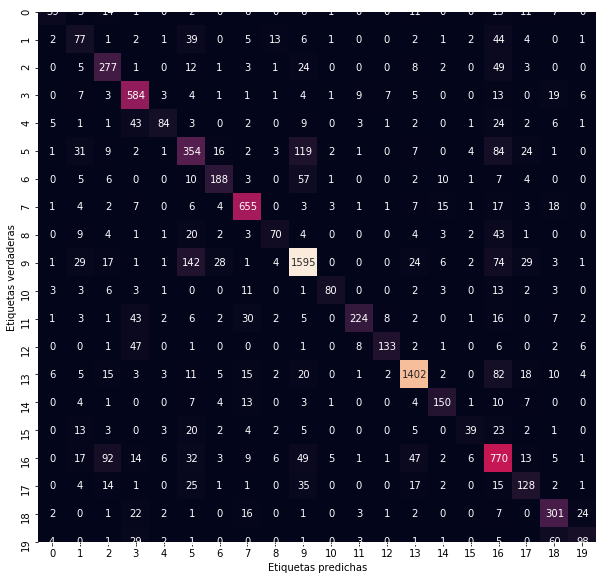

In [60]:
mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas');

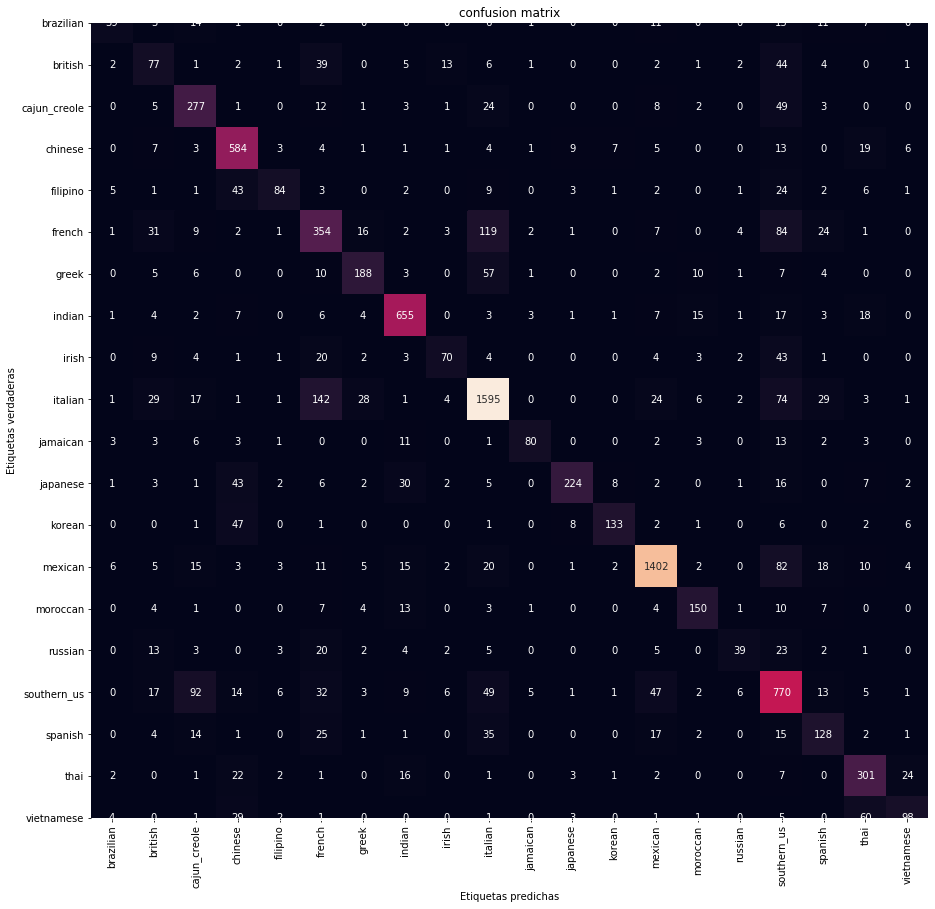

In [61]:
plt.figure(figsize=(15, 15))
classes = unique_labels(y_test, y_pred)

# #tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, labels= classes, rotation=90)
# plt.yticks(tick_marks, labels= classes, rotation=-45)
plt.title("confusion matrix")

mat = confusion_matrix(y_test, y_pred)
ax=sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
    
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')
ax.set_xticklabels(classes,rotation=90)
ax.set_yticklabels(classes,rotation=0);

In [64]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

   brazilian       0.60      0.34      0.43       116
     british       0.35      0.38      0.37       201
cajun_creole       0.59      0.72      0.65       386
     chinese       0.73      0.87      0.79       668
    filipino       0.76      0.45      0.56       188
      french       0.51      0.54      0.52       661
       greek       0.73      0.64      0.68       294
      indian       0.84      0.88      0.86       748
       irish       0.67      0.42      0.52       167
     italian       0.82      0.81      0.82      1958
    jamaican       0.84      0.61      0.71       131
    japanese       0.88      0.63      0.74       355
      korean       0.86      0.64      0.73       208
     mexican       0.90      0.87      0.89      1606
    moroccan       0.76      0.73      0.74       205
     russian       0.65      0.32      0.43       122
 southern_us       0.58      0.71      0.64      1079
     spanish       0.51    

# Predicciones sobre datos nuevos

In [ ]:
data_test = pd.read_json('test.json')
data_test.head()

In [ ]:
data_test.shape

In [ ]:
#data_test['ingr_lst'] = data_test['ingredients'].apply(lambda x: [item.replace(' ','') for item in x])
data_test['ingr_str'] = data_test['ingredients'].apply(lambda x: ' '.join(x))
data_test.head()
#data_test.head()
#X_new = data_test['ingr_str']
#X_new = vec.transform(X_new)

In [ ]:
X = data_test['ingr_str']

y_pred_new = pipeline_best.predict(X)

d = {'id':data_test['id'],
    'ingredients':data_test['ingredients'],
    'predictions':y_pred_new}

predicted_data = pd.DataFrame(d)
predicted_data.sample(10)

In [ ]:
pd.Series(y_pred_new).value_counts(normalize=True)

In [ ]:
data_train['cuisine'].value_counts(normalize=True)